**date:** Date in format dd/mm/yyyy

**time:** time in format hh:mm:ss

**globalactivepower:** household global minute-averaged active power (in kilowatt)

**globalreactivepower:** household global minute-averaged reactive power (in kilowatt)

**voltage:** minute-averaged voltage (in volt)

**global_intensity:** household global minute-averaged current intensity (in ampere)

**submetering1:** energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

**submetering2:** energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

**submetering3:** energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime

%matplotlib inline
sns.set()

In [2]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# ! pip install pmdarima #if not installed

In [4]:
df = pd.read_csv("household_power_consumption.txt", sep=";", low_memory = False)
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [5]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

# Dataset preparation

In [6]:
df.shape

(2075259, 9)

In [7]:
df = df.dropna()

In [8]:
df.shape

(2049280, 9)

In [9]:
df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y')
df["Time"]  = pd.to_datetime(df["Time"])
df["Global_active_power"] = df["Global_active_power"].astype('float')
df["Sub_metering_1"] = df["Sub_metering_1"].astype('float')
df["Sub_metering_2"] = df["Sub_metering_2"].astype('float')
df["Sub_metering_3"] = df["Sub_metering_3"].astype('float')

In [10]:
df = df.drop(['Global_reactive_power','Voltage','Global_intensity'], axis=1)

In [11]:
df.dtypes

Date                   datetime64[ns]
Time                   datetime64[ns]
Global_active_power           float64
Sub_metering_1                float64
Sub_metering_2                float64
Sub_metering_3                float64
dtype: object

# Monthly data analysis

In [12]:
dfm = df.groupby(pd.Grouper(key='Date', freq='1M')).sum()
dfm.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,
2006-12-31,41813.282,27460.0,48712.0,162951.0
2007-01-31,69011.862,56433.0,79274.0,329578.0
2007-02-28,56488.886,47584.0,64604.0,270274.0
2007-03-31,58862.192,60769.0,104762.0,290361.0
2007-04-30,35181.466,42078.0,38417.0,189503.0


In [13]:
dfm.index

DatetimeIndex(['2006-12-31', '2007-01-31', '2007-02-28', '2007-03-31',
               '2007-04-30', '2007-05-31', '2007-06-30', '2007-07-31',
               '2007-08-31', '2007-09-30', '2007-10-31', '2007-11-30',
               '2007-12-31', '2008-01-31', '2008-02-29', '2008-03-31',
               '2008-04-30', '2008-05-31', '2008-06-30', '2008-07-31',
               '2008-08-31', '2008-09-30', '2008-10-31', '2008-11-30',
               '2008-12-31', '2009-01-31', '2009-02-28', '2009-03-31',
               '2009-04-30', '2009-05-31', '2009-06-30', '2009-07-31',
               '2009-08-31', '2009-09-30', '2009-10-31', '2009-11-30',
               '2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30'],
              dtype='datetime64[ns]', name='Date', freq='M')

## Seasonal decomposition in order to check trends, seasonality

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

power_sd = seasonal_decompose(dfm['Global_active_power'], model='add')
sub1_sd = seasonal_decompose(dfm['Sub_metering_1'], model='add')
sub2_sd = seasonal_decompose(dfm['Sub_metering_2'], model='add')
sub3_sd = seasonal_decompose(dfm['Sub_metering_3'], model='add')

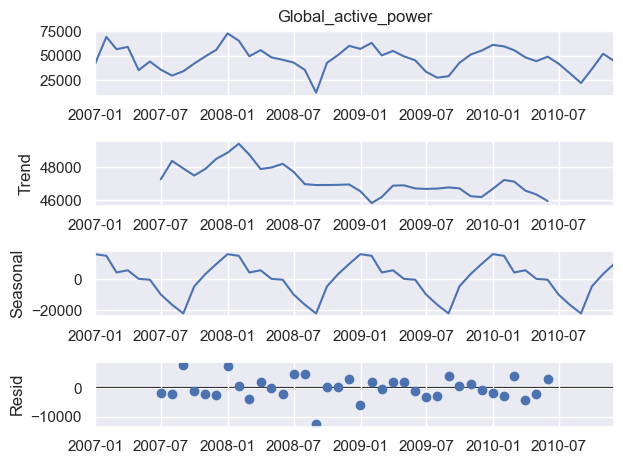

In [15]:
power_sd.plot();

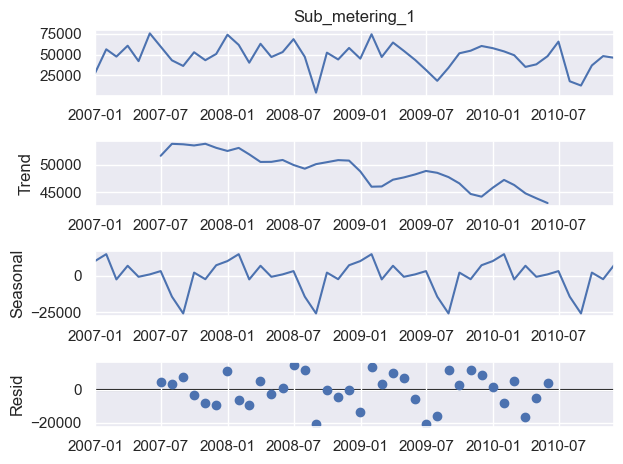

In [16]:
sub1_sd.plot();

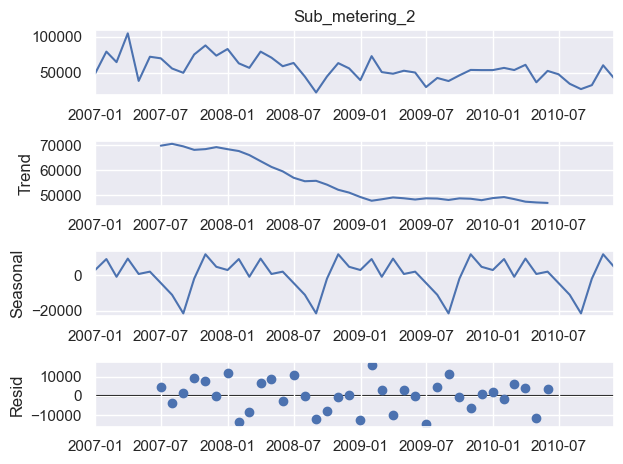

In [17]:
sub2_sd.plot();

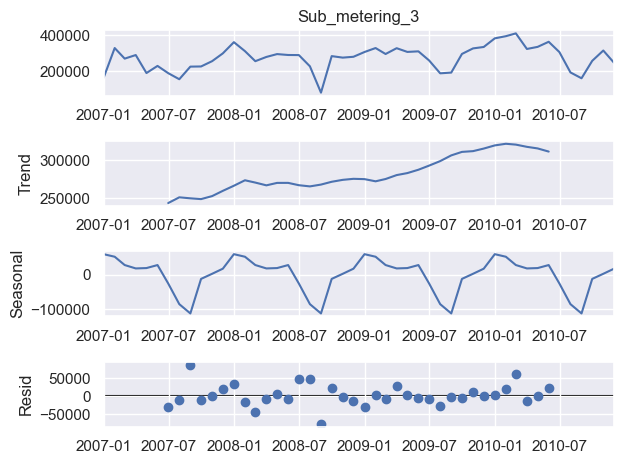

In [18]:
sub3_sd.plot();

## Simple models (SES i TES)

In [19]:
span = 12 #number of months
alpha = 2/(span+1)

#dfd.index = pd.DatetimeIndex(dfd.index).to_period('D')

# SES for all variables
dfm['SES_power'] = SimpleExpSmoothing(dfm['Global_active_power']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfm['SES_sub1'] = SimpleExpSmoothing(dfm['Sub_metering_1']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfm['SES_sub2'] = SimpleExpSmoothing(dfm['Sub_metering_2']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfm['SES_sub3'] = SimpleExpSmoothing(dfm['Sub_metering_3']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

# TES for power and sub3, as it seems to be most reasonable at first glance
dfm['TES_power'] = ExponentialSmoothing(dfm['Global_active_power'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
dfm['TES_sub3'] = ExponentialSmoothing(dfm['Sub_metering_3'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

# TES for sub1, sub2 added after checking seasonality in further part
dfm['TES_sub1'] = ExponentialSmoothing(dfm['Sub_metering_1'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
dfm['TES_sub2'] = ExponentialSmoothing(dfm['Sub_metering_2'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

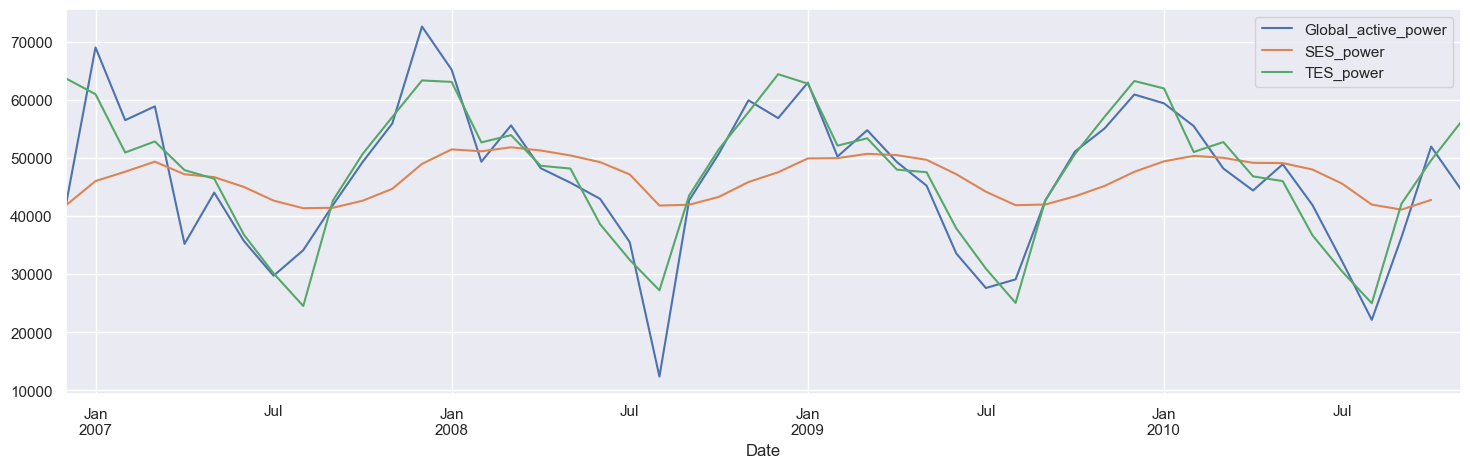

In [20]:
dfm[['Global_active_power','SES_power','TES_power']].plot(figsize=(18,5));

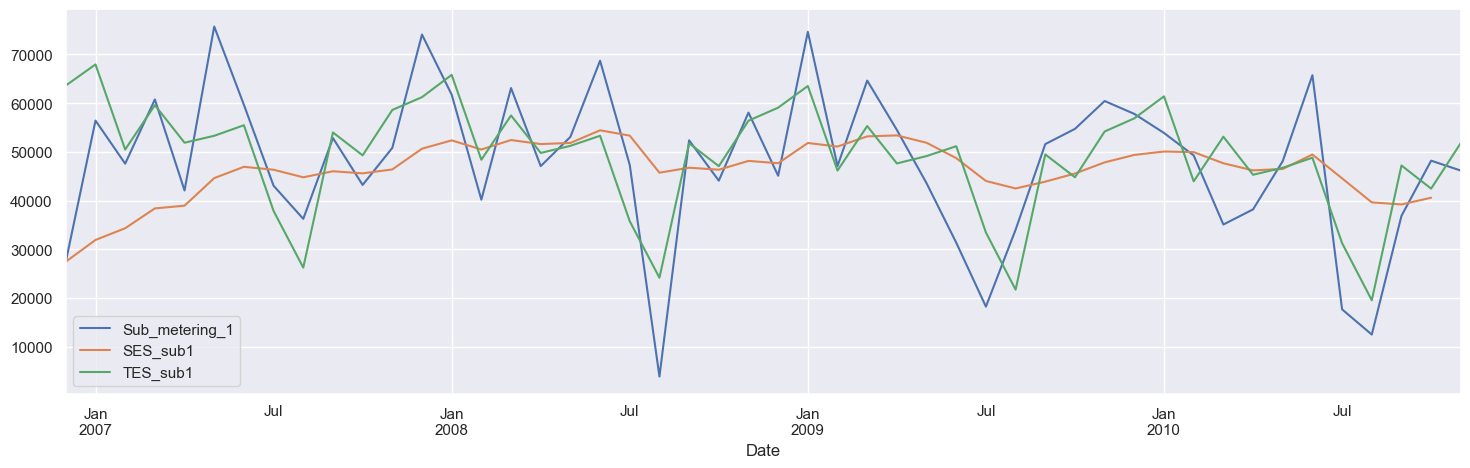

In [21]:
dfm[['Sub_metering_1','SES_sub1','TES_sub1']].plot(figsize=(18,5));

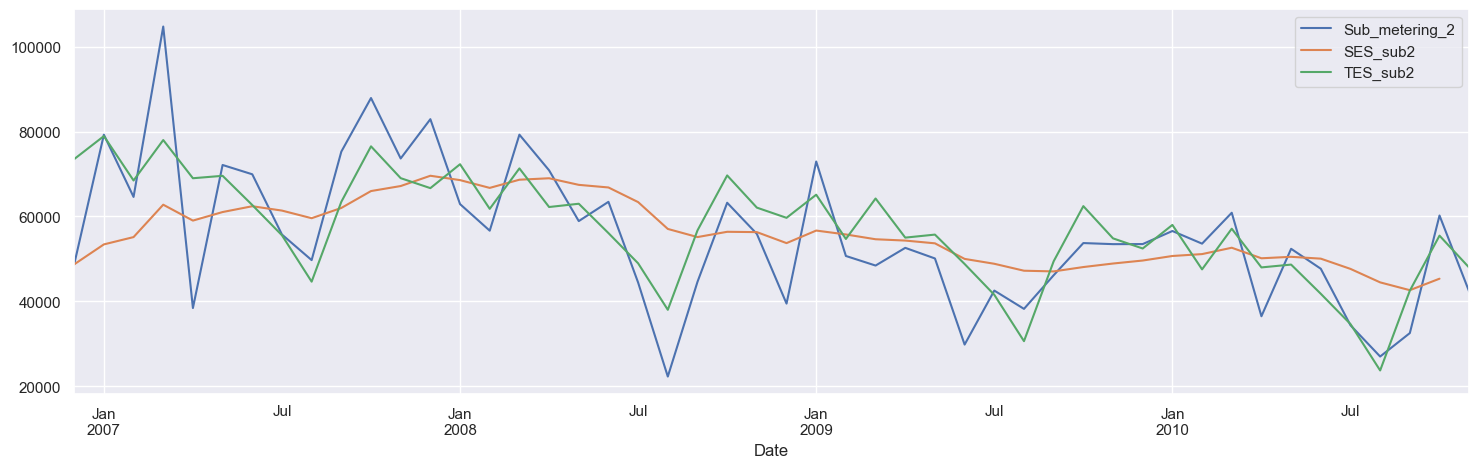

In [22]:
dfm[['Sub_metering_2','SES_sub2','TES_sub2']].plot(figsize=(18,5));

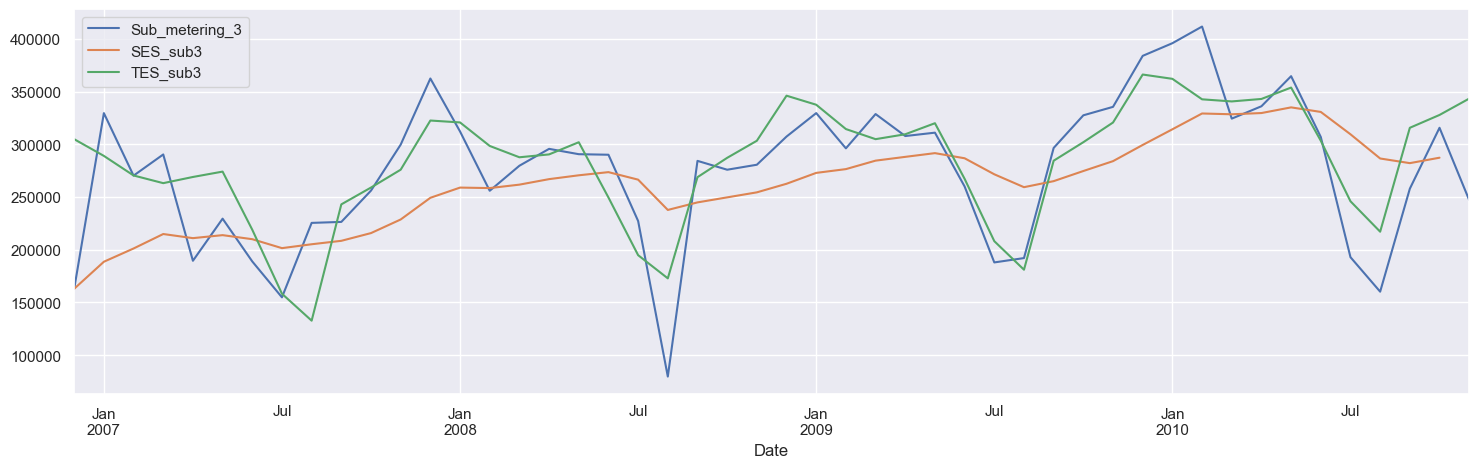

In [23]:
dfm[['Sub_metering_3','SES_sub3','TES_sub3']].plot(figsize=(18,5));

### Monthly data prognosis - TES dla global, sub3; SES dla sub1, sub2

#### Global active power - TES

In [24]:
# dividing model into training and test in order to validate the estimation using MAE and RMSE

month_train = dfm.iloc[:36]
month_test = dfm.iloc[36:]

In [25]:
# checking TES model efficiency for Global active power

power_train_model = ExponentialSmoothing(month_train['Global_active_power'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = power_train_model.forecast(12).rename('TES_power_Forecast')

# evaluation based on errors - errors to be solwer than STD
power_TES_MAE = mean_absolute_error(month_test['Global_active_power'],test_predictions)
power_TES_RMSE = np.sqrt(mean_squared_error(month_test['Global_active_power'],test_predictions))
power_TES_STD = month_test['Global_active_power'].std()

print("MAE:", power_TES_MAE, "RMSE:", power_TES_RMSE, " STD:", power_TES_STD)

MAE: 4865.596608567722 RMSE: 6123.373769643343  STD: 11336.01333086247


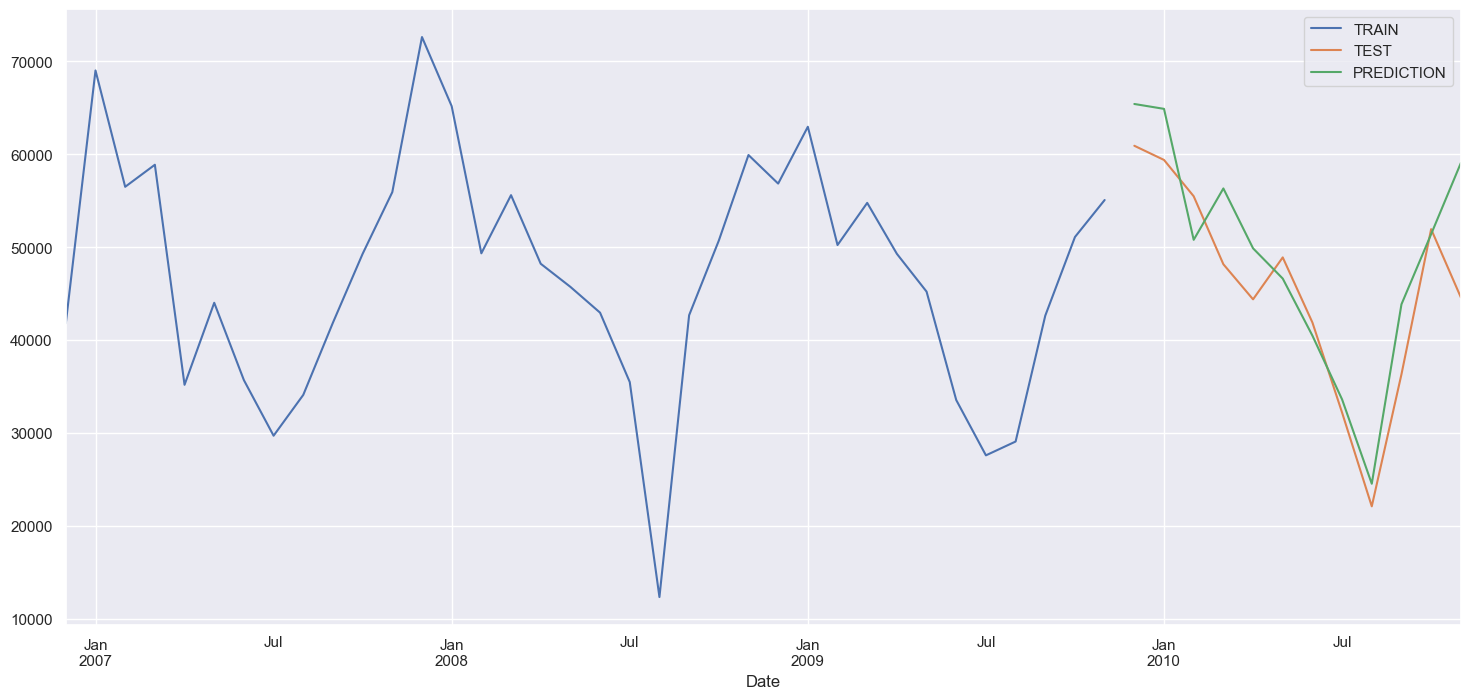

In [26]:
# MAE, RMSE < STD, which is ok
# plotting

month_train['Global_active_power'].plot(legend=True,label='TRAIN')
month_test['Global_active_power'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

NameError: name 'power_TES_predictions' is not defined

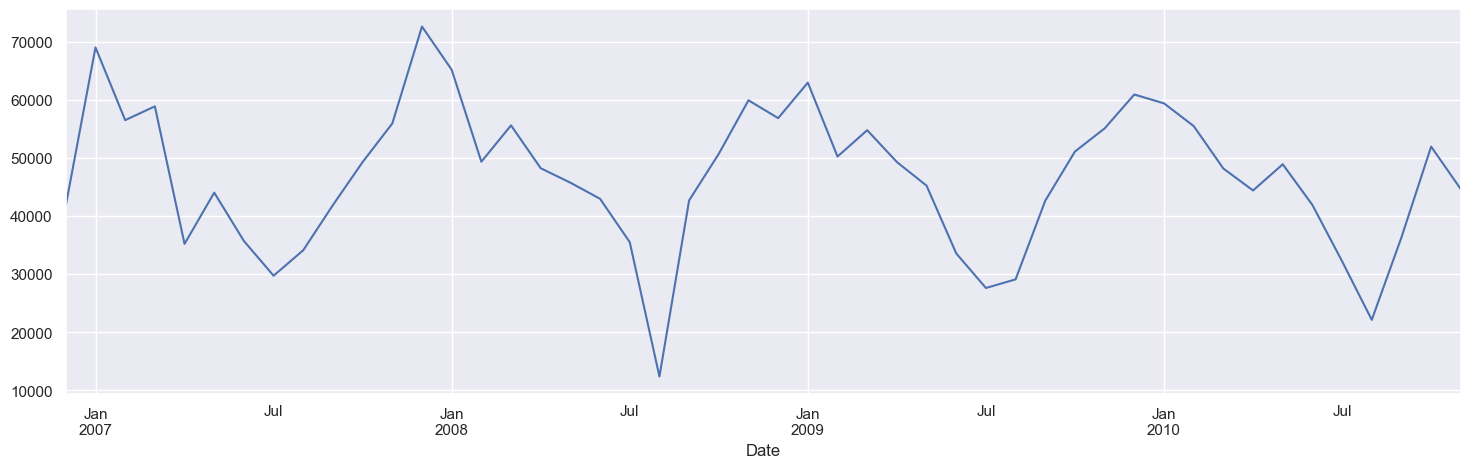

In [27]:
# prediction - no comparison, however, previous calculations suggest the prediction is well 

power_TES_model = ExponentialSmoothing(dfm['Global_active_power'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = power_TES_model.forecast(12)

dfm['Global_active_power'].plot(figsize=(18,5))
power_TES_predictions.plot();

#### Sub3 - TES

In [28]:
# checking TES model efficiency for sub3

sub3_train_model = ExponentialSmoothing(month_train['Sub_metering_3'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions3 = sub3_train_model.forecast(12).rename('TES_sub3_Forecast')

sub3_TES_MAE = mean_absolute_error(month_test['Sub_metering_3'],test_predictions3)
sub3_TES_RMSE = np.sqrt(mean_squared_error(month_test['Sub_metering_3'],test_predictions3))
sub3_TES_STD = month_test['Sub_metering_3'].std()

print("MAE:", sub3_TES_MAE, "RMSE:", sub3_TES_RMSE, " STD:", sub3_TES_STD)

MAE: 40680.96114813715 RMSE: 52074.70087441025  STD: 79706.64793060446


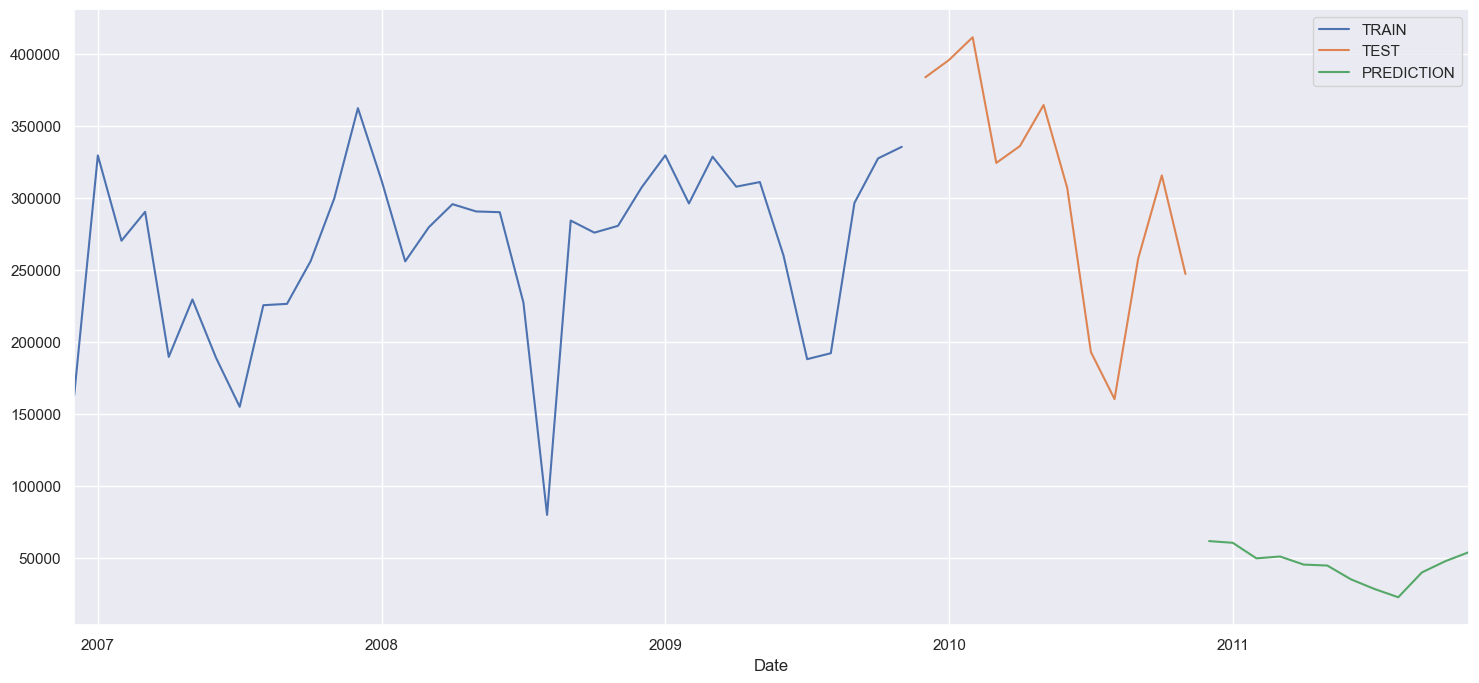

In [29]:
# MAE, RMSE < STD, which is ok
# plotting

month_train['Sub_metering_3'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_3'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

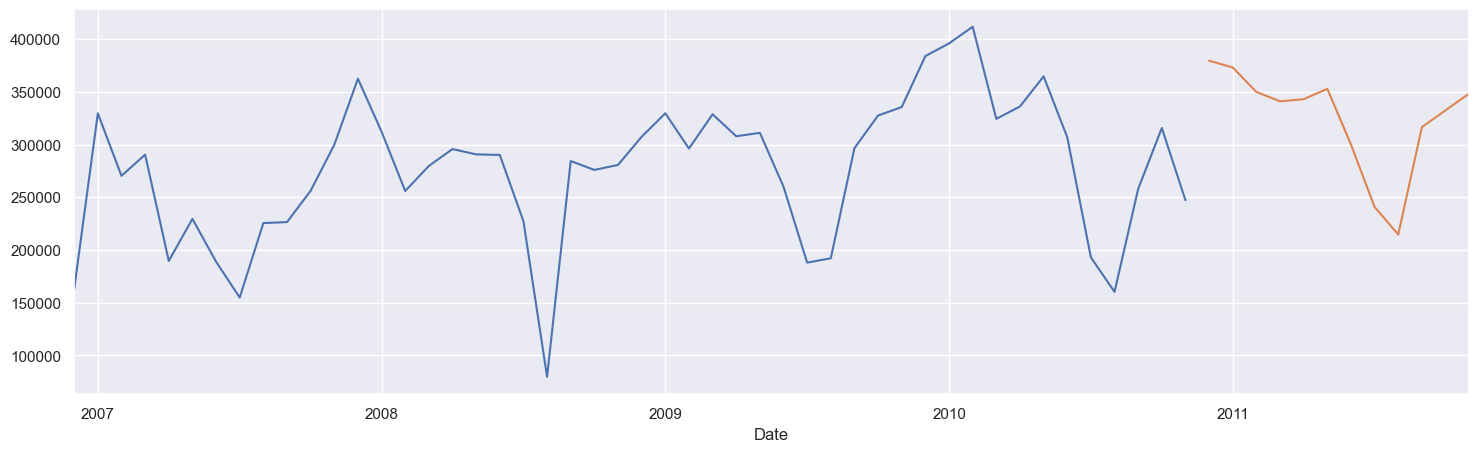

In [30]:
# prediction - no comparison, however, previous calculations suggest the prediction is well 

sub3_TES_model = ExponentialSmoothing(dfm['Sub_metering_3'],trend='add',seasonal='add',seasonal_periods=12).fit()
sub3_TES_predictions = sub3_TES_model.forecast(12)

dfm['Sub_metering_3'].plot(figsize=(18,5))
sub3_TES_predictions.plot();

#### Sub1 SES

In [31]:
span = 12
alpha = 2/(span+1)

sub1_train_model = SimpleExpSmoothing(month_train['Sub_metering_1']).fit(smoothing_level=alpha,optimized=False)
test_predictions = sub1_train_model.forecast(12).rename('SES_sub1_Forecast')


print(mean_absolute_error(month_test['Sub_metering_1'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_1'],test_predictions)))
print(month_test['Sub_metering_1'].std())

11377.583333333334
15806.473273996042
15519.070433297104


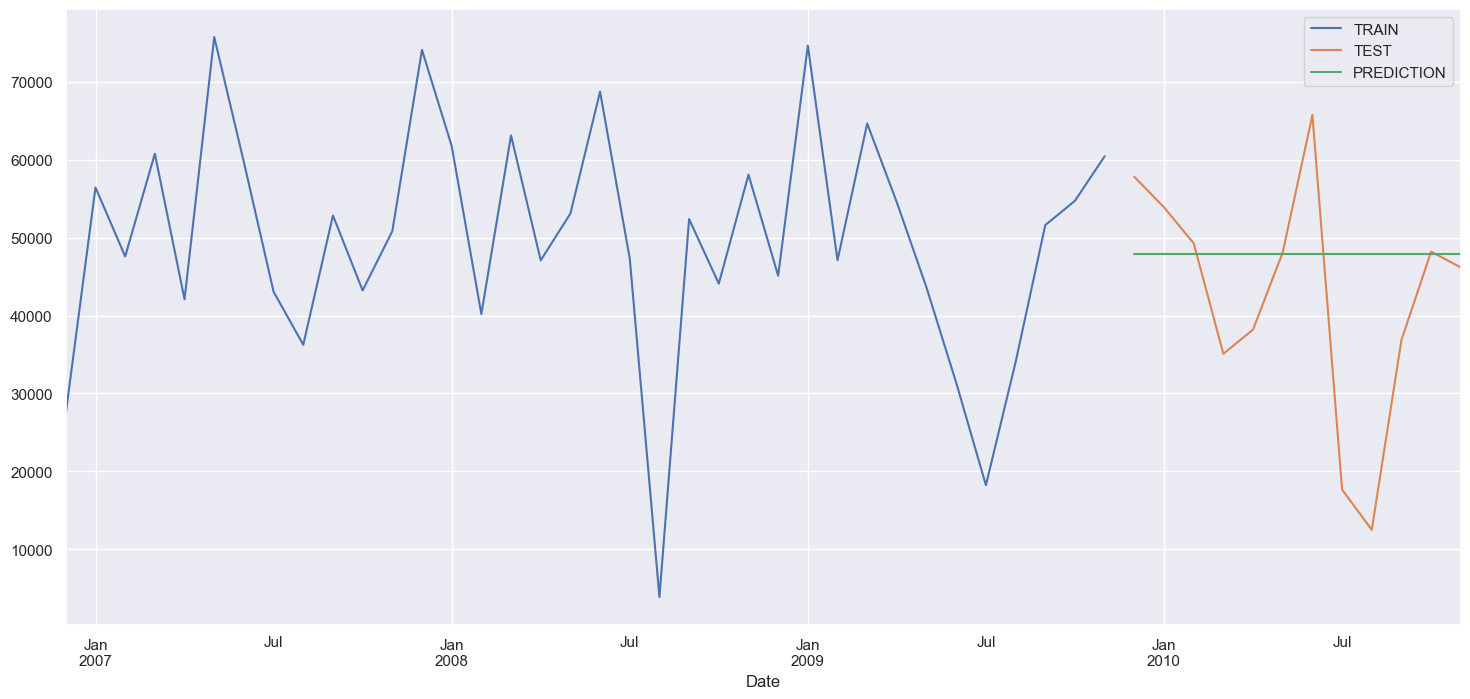

In [32]:
# high errors exceeding STD

month_train['Sub_metering_1'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_1'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Sub 2 SES

In [33]:
span = 12
alpha = 2/(span+1)

sub2_train_model = SimpleExpSmoothing(month_train['Sub_metering_2']).fit(smoothing_level=alpha,optimized=False)
test_predictions = sub2_train_model.forecast(12).rename('SES_sub2_Forecast')

from sklearn.metrics import mean_squared_error,mean_absolute_error

print(mean_absolute_error(month_test['Sub_metering_2'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_2'],test_predictions)))
print(month_test['Sub_metering_2'].std())

9736.083333333334
11349.987445271148
11573.986674343407


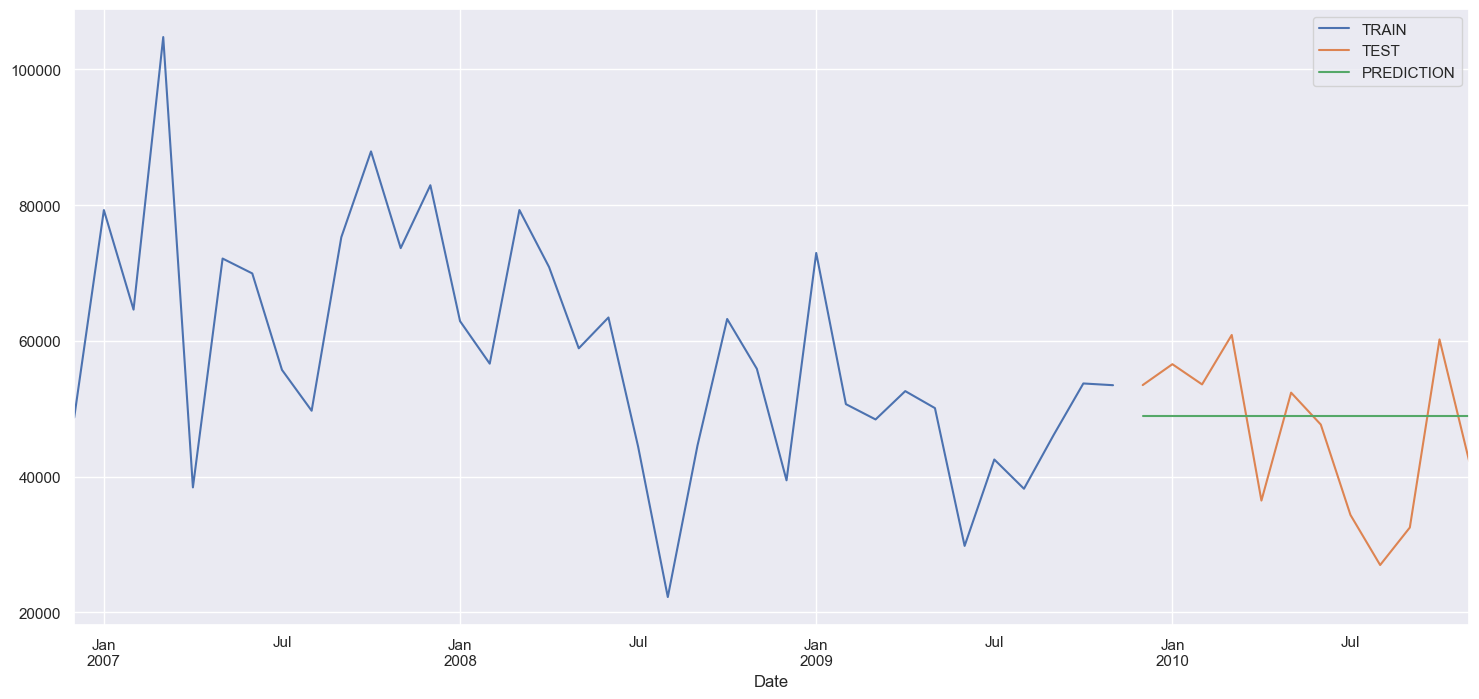

In [34]:
# high errors exceeding STD

month_train['Sub_metering_2'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_2'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

### Preparing TES for variables sub1, sub2 expecting better results

In [35]:
# checking TES model efficiency for sub1

sub1_train_model = ExponentialSmoothing(month_train['Sub_metering_1'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = sub1_train_model.forecast(12).rename('TES_sub1_Forecast')

print(mean_absolute_error(month_test['Sub_metering_1'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_1'],test_predictions)))
print(month_test['Sub_metering_1'].std())

9222.586316017945
11779.772316243756
15519.070433297104


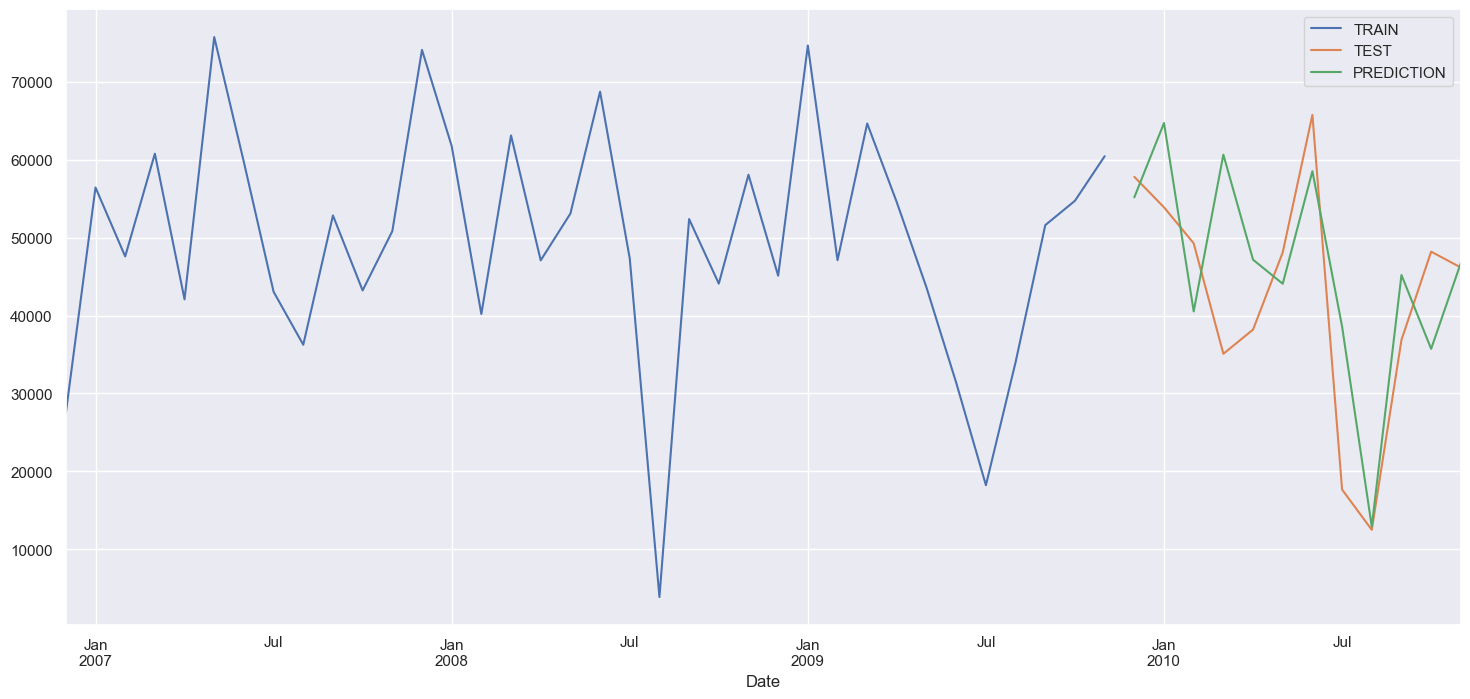

In [36]:
# MAE, RMSE < STD, which is ok
# plotting:

month_train['Sub_metering_1'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_1'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

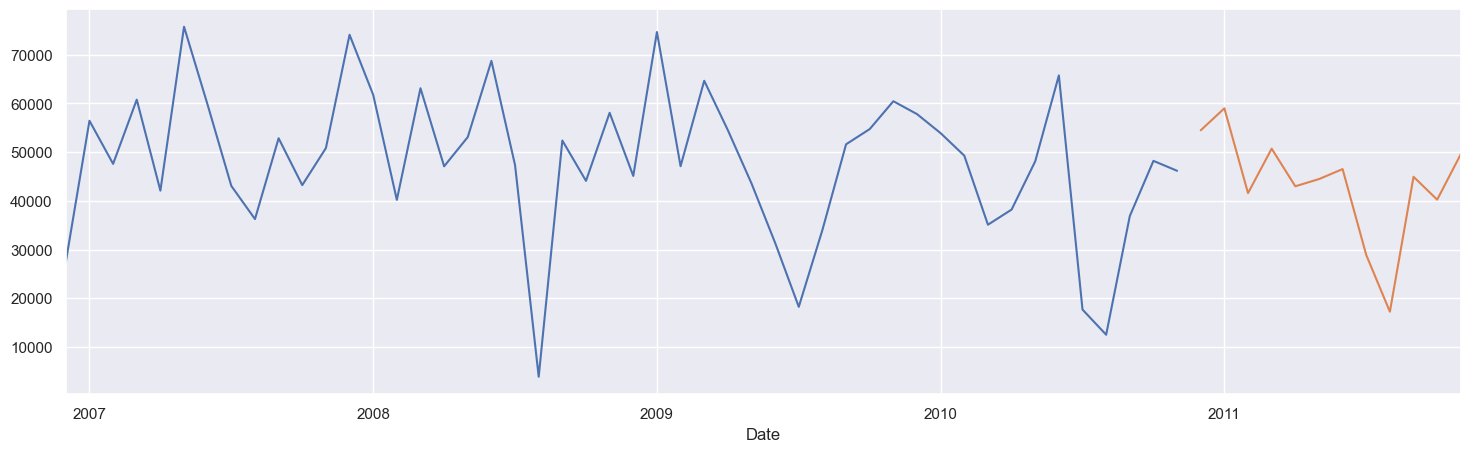

In [37]:
sub1_TES_model = ExponentialSmoothing(dfm['Sub_metering_1'],trend='add',seasonal='add',seasonal_periods=12).fit()
sub1_TES_predictions = sub1_TES_model.forecast(12)

dfm['Sub_metering_1'].plot(figsize=(18,5))
sub1_TES_predictions.plot();

In [38]:
# checking TES model efficiency for sub2

sub2_train_model = ExponentialSmoothing(month_train['Sub_metering_2'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = sub2_train_model.forecast(12).rename('TES_sub2_Forecast')

print(mean_absolute_error(month_test['Sub_metering_2'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_2'],test_predictions)))
print(month_test['Sub_metering_2'].std())

5957.018571412135
7485.292044107478
11573.986674343407


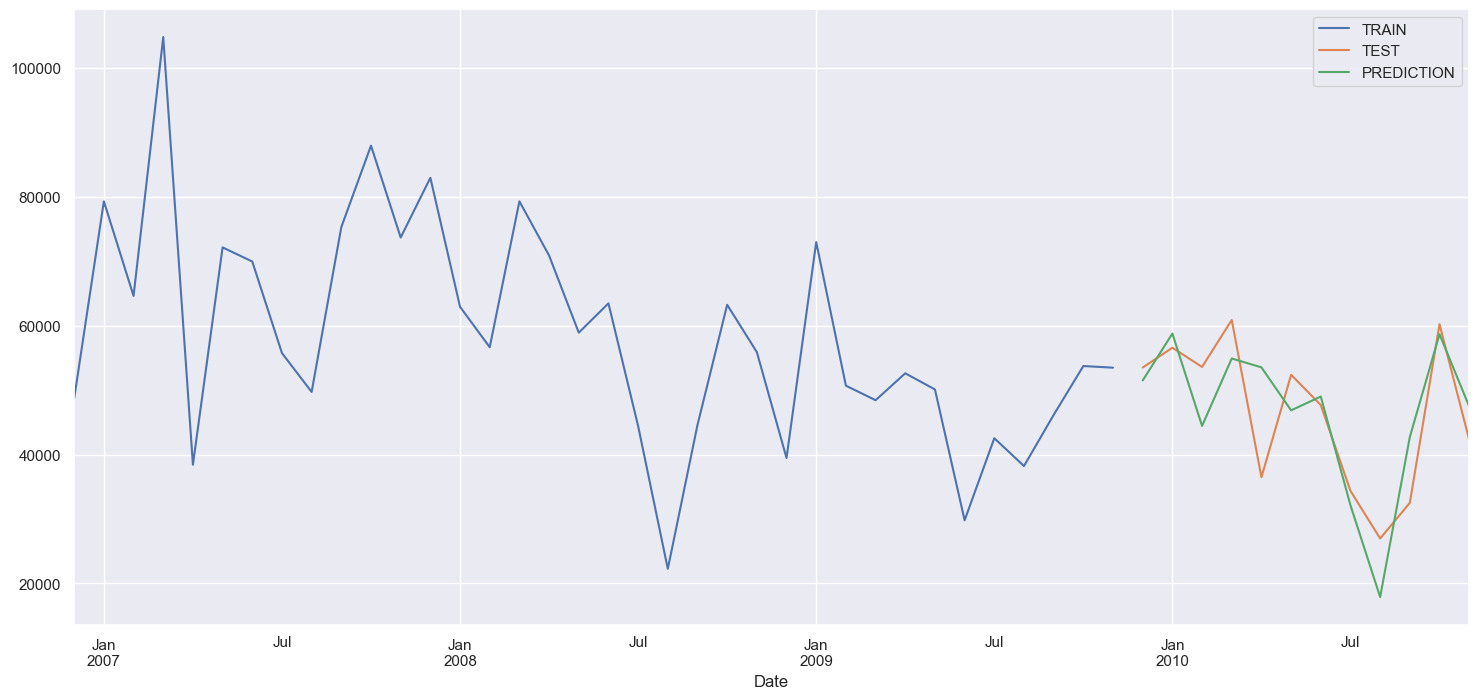

In [39]:
# MAE, RMSE < STD, which is ok
# plotting:

month_train['Sub_metering_2'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_2'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

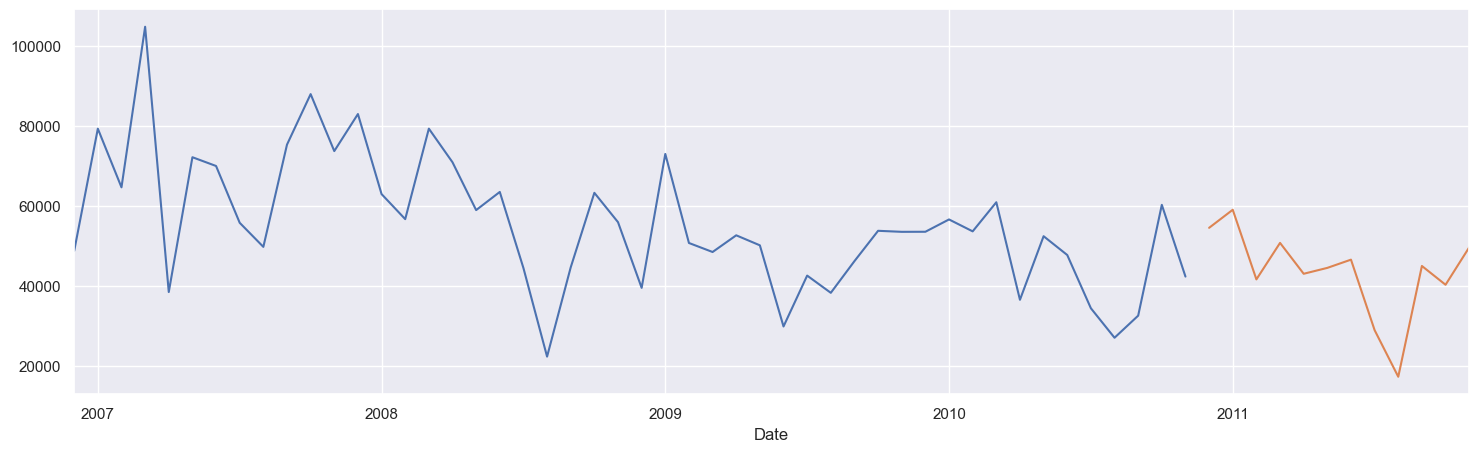

In [40]:
sub2_TES_model = ExponentialSmoothing(dfm['Sub_metering_2'],trend='add',seasonal='add',seasonal_periods=12).fit()
sub2_TES_predictions = sub1_TES_model.forecast(12)

dfm['Sub_metering_2'].plot(figsize=(18,5))
sub2_TES_predictions.plot();

#### Wnioski:

- TES provides good results for power, sub3
- SES provides better results for sub1, which TES for sub2
- at first glance sub3 and power are the ones with seasonality, but decomposition shows that all of them are seasonal


### Stationarity test

In [41]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [42]:
adf_test(dfm['Global_active_power'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.597298e+00
p-value                 6.874210e-09
# lags used             7.000000e+00
# observations          4.000000e+01
critical value (1%)    -3.605565e+00
critical value (5%)    -2.937069e+00
critical value (10%)   -2.606986e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [43]:
adf_test(dfm['Sub_metering_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.669254e+00
p-value                 9.001166e-07
# lags used             0.000000e+00
# observations          4.700000e+01
critical value (1%)    -3.577848e+00
critical value (5%)    -2.925338e+00
critical value (10%)   -2.600774e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [44]:
adf_test(dfm['Sub_metering_2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.734022
p-value                  0.000073
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [45]:
adf_test(dfm['Sub_metering_3'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.989384
p-value                  0.001467
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### It turnes out that all of the variables are stationary

## ARIMA, SARIMA for monthly data

### ARIMA dla global power

In [46]:
stepwise_fit = auto_arima(dfm['Global_active_power'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=763.929, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=761.683, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=761.652, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=761.537, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.752, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=763.674, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=763.673, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=765.601, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=760.400, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=759.873, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=762.569, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.349 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -378.876
Date:                  Fri, 14 Apr 2023   AIC                            759.752
Time:                          16:27:42   BIC                            761.336
Sample:                               0   HQIC                           760.305
                                   - 48                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.652e+07   1.12e+07      6.857      0.000    5.46e+07    9.84e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                14.90
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.79
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
auto_arima(dfm['Global_active_power'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -509.417
Date:                Fri, 14 Apr 2023   AIC                           1024.835
Time:                        16:27:43   BIC                           1030.449
Sample:                             0   HQIC                          1026.956
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.925e+04   5285.134      3.642      0.000    8888.794    2.96e+04
ar.L1          0.5849      0.119      4.930      0.000       0.352       0.817
sigma2      9.763e+07      0.206   4.74e+08      0.000    9.76e+07    9.76e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.57   Prob(JB):                         0.66
Heteroskedasticity (H):               0.47   Skew:                            -0.11
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.33e+28. Standard errors may be unstable.
"""

In [48]:
# dividing model into training and test to evaluate estimation using MAE & RMSE

month_train = dfm.iloc[:36]
month_test = dfm.iloc[36:]

In [49]:
model_power_ARIMA = ARIMA(month_train['Global_active_power'],order=(1,0,0))
results_power_ARIMA = model_power_ARIMA.fit()

results_power_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   36
Model:                  ARIMA(1, 0, 0)   Log Likelihood                -384.072
Date:                 Fri, 14 Apr 2023   AIC                            774.144
Time:                         16:27:44   BIC                            778.894
Sample:                     12-31-2006   HQIC                           775.802
                          - 11-30-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.697e+04   4051.410     11.593      0.000     3.9e+04    5.49e+04
ar.L1          0.5500      0.145      3.783      0.000       0.265       0.835
sigma2      1.096e+08      0.018   5.99e+09      0.000     1.1e+08     1.1e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.72   Prob(JB):                         0.69
Heteroskedasticity (H):               0.49   Skew:                            -0.15
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.55e+26. Standard errors may be unstable.
"""

In [50]:
dfm.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,SES_power,SES_sub1,SES_sub2,SES_sub3,TES_power,TES_sub3,TES_sub1,TES_sub2
Date,,,,,,,,,,,,
2006-12-31,41813.282,27460.0,48712.0,162951.0,41813.282000,27460.000000,48712.000000,162951.000000,63679.872196,304853.960522,63624.088068,73517.664394
2007-01-31,69011.862,56433.0,79274.0,329578.0,45997.678923,31917.384615,53413.846154,188585.923077,60955.244825,288996.269491,67960.223122,78942.035880
2007-02-28,56488.886,47584.0,64604.0,270274.0,47611.710781,34327.633136,55135.408284,201153.319527,50918.421990,270430.250811,50486.184875,68477.881585
2007-03-31,58862.192,60769.0,104762.0,290361.0,49342.554046,38395.535731,62770.268548,214877.578061,52821.990715,263143.042019,59600.185376,78012.087326
2007-04-30,35181.466,42078.0,38417.0,189503.0,47163.925115,38962.068695,59023.611848,210973.796821,47884.801335,269006.899670,51886.167317,69007.719675


In [51]:
# checking second model, however, configuration (1, 0, 0) turnes out to be better

model_power_ARIMA2 = ARIMA(month_train['Global_active_power'],order=(0,1,0))
results2 = model_power_ARIMA2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   36
Model:                  ARIMA(0, 1, 0)   Log Likelihood                -377.912
Date:                 Fri, 14 Apr 2023   AIC                            757.823
Time:                         16:27:45   BIC                            759.379
Sample:                     12-31-2006   HQIC                           758.360
                          - 11-30-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.36e+08   2.92e+07      4.657      0.000    7.88e+07    1.93e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.41   Prob(JB):                         0.74
Heteroskedasticity (H):               0.34   Skew:                             0.28
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
start=len(month_train)
end=len(month_train)+len(month_test)-1
power_arima_predictions = results_power_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'Global_active_power')]

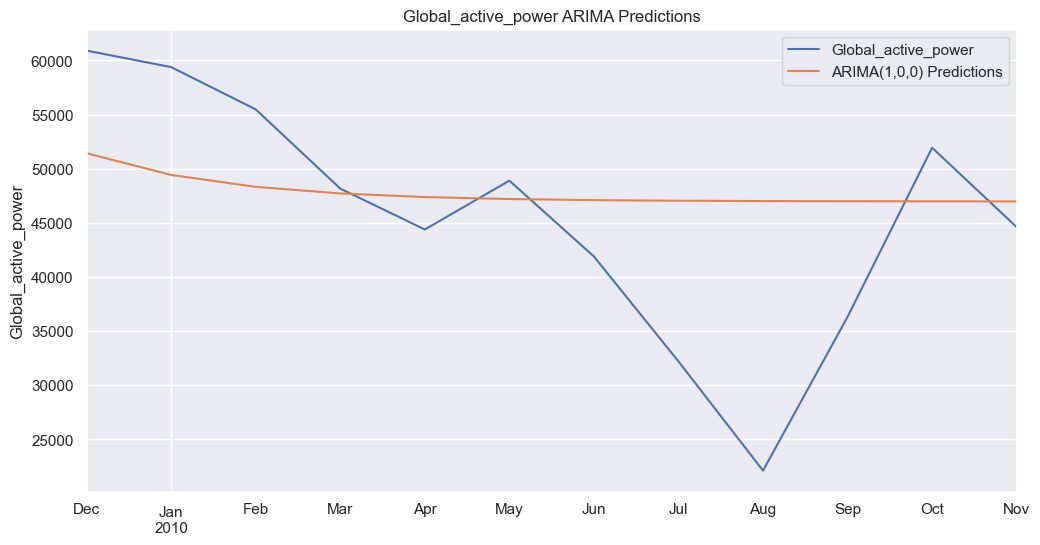

In [53]:
title = 'Global_active_power ARIMA Predictions'
ylabel='Global_active_power'
xlabel='' # we don't really need a label here

ax = month_test['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
power_arima_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


In [54]:
power_ARIMA_MAE = mean_absolute_error(month_test['Global_active_power'], power_arima_predictions)
power_ARIMA_RMSE = np.sqrt(mean_squared_error(month_test['Global_active_power'], power_arima_predictions))
power_ARIMA_STD = month_test['Global_active_power'].std()

print("MAE:", power_ARIMA_MAE, "RMSE:", power_ARIMA_RMSE, " STD:", power_ARIMA_STD)

MAE: 7892.399963508037 RMSE: 10264.385779796223  STD: 11336.01333086247


##### Error higher than with TES (TES: 6853.065180493326)

### Prediction with ARIMA

In [55]:
model = ARIMA(dfm['Global_active_power'],order=(1,0,0))
results = model.fit()
fcast = results.predict(len(dfm),len(dfm)+11,typ='levels').rename('ARIMA(1,0,0) Forecast')

[Text(0.5, 0, ''), Text(0, 0.5, 'Global_active_power')]

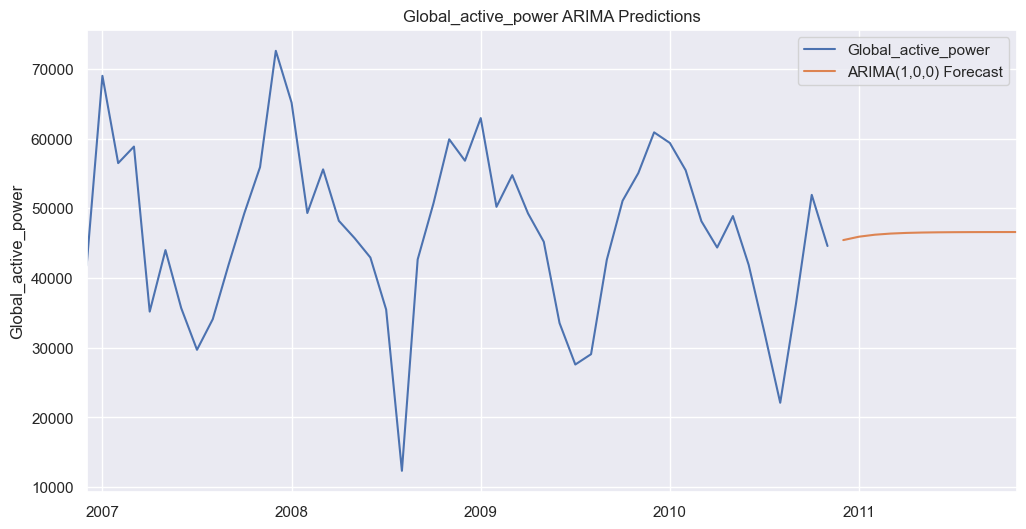

In [56]:
ax = dfm['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### ARIMA provides worse results than TES; checking SARIMA

In [57]:
auto_arima(dfm['Global_active_power'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -505.595
Date:                            Fri, 14 Apr 2023   AIC                           1019.191
Time:                                    16:27:53   BIC                           1026.676
Sample:                                         0   HQIC                          1022.019
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.925e+04   8860.148      2.172      0.030    1881.895    3.66e+04
ar.L1          0.2926      0.207      1.414      0.158      -0.113       0.698
ar.S.L12       0.4195      0.212      1.978      0.048       0.004       0.835
sigma2      9.763e+07      2.321   4.21e+07      0.000    9.76e+07    9.76e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):                 8.90
Prob(Q):                              0.30   Prob(JB):                         0.01
Heteroskedasticity (H):               0.31   Skew:                            -0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.84e+22. Standard errors may be unstable.
"""

In [58]:
model = SARIMAX(month_train['Global_active_power'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13719D+01    |proj g|=  6.35376D-02

At iterate    5    f=  1.07797D+01    |proj g|=  2.17861D-02

At iterate   10    f=  1.07792D+01    |proj g|=  1.23778D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   1.238D-05   1.078D+01
  F =   10.779237851569880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -388.053
Date:                            Fri, 14 Apr 2023   AIC                            782.105
Time:                                    16:27:53   BIC                            786.856
Sample:                                12-31-2006   HQIC                           783.763
                                     - 11-30-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9367      0.078     12.083      0.000       0.785       1.089
ar.S.L12       0.3708      0.226      1.640      0.101      -0.072       0.814
sigma2      1.388e+08   5.91e-10   2.35e+17      0.000    1.39e+08    1.39e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.27   Prob(JB):                         0.81
Heteroskedasticity (H):               0.28   Skew:                             0.04
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+34. Standard errors may be unstable.
"""

In [59]:
predictions_SARIMA = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Predictions')

In [60]:
power_SARIMA_MAE = mean_absolute_error(month_test['Global_active_power'], predictions_SARIMA)
power_SARIMA_RMSE = np.sqrt(mean_squared_error(month_test['Global_active_power'], predictions_SARIMA))
power_SARIMA_STD = month_test['Global_active_power'].std()

print("MAE:", power_SARIMA_MAE, "RMSE:", power_SARIMA_RMSE, " STD:", power_SARIMA_STD)

MAE: 7387.993377361109 RMSE: 8442.932711586682  STD: 11336.01333086247


#### SARIMA provides lower error than ARIMA, however, still higher than TES

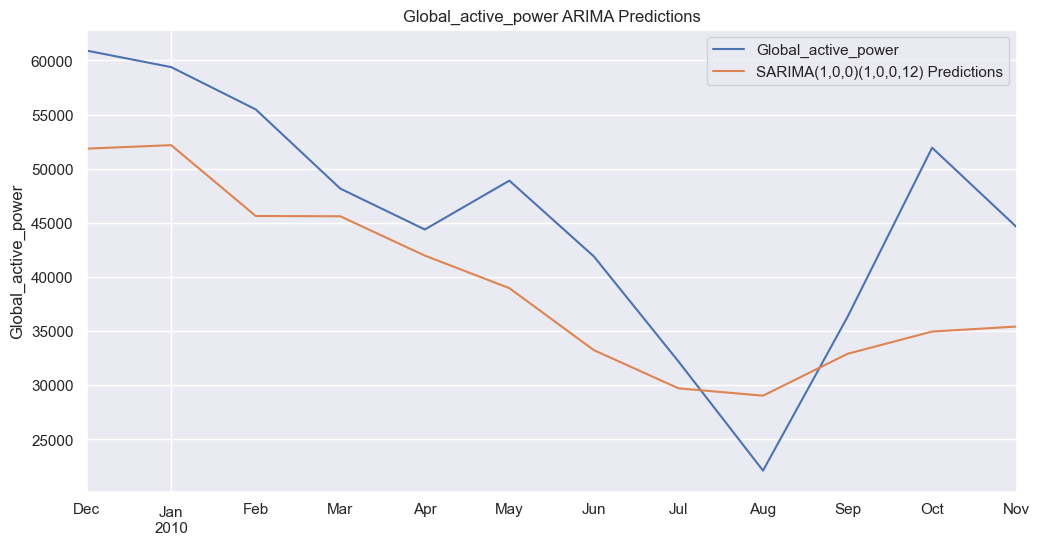

In [61]:
ax = month_test['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
predictions_SARIMA.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [62]:
model = SARIMAX(dfm['Global_active_power'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
fcast = results.predict(len(dfm),len(dfm)+11,typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11215D+01    |proj g|=  5.22400D-02

At iterate    5    f=  1.06912D+01    |proj g|=  3.66753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     14      1     0     0   1.554D-05   1.069D+01
  F =   10.691202845058060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


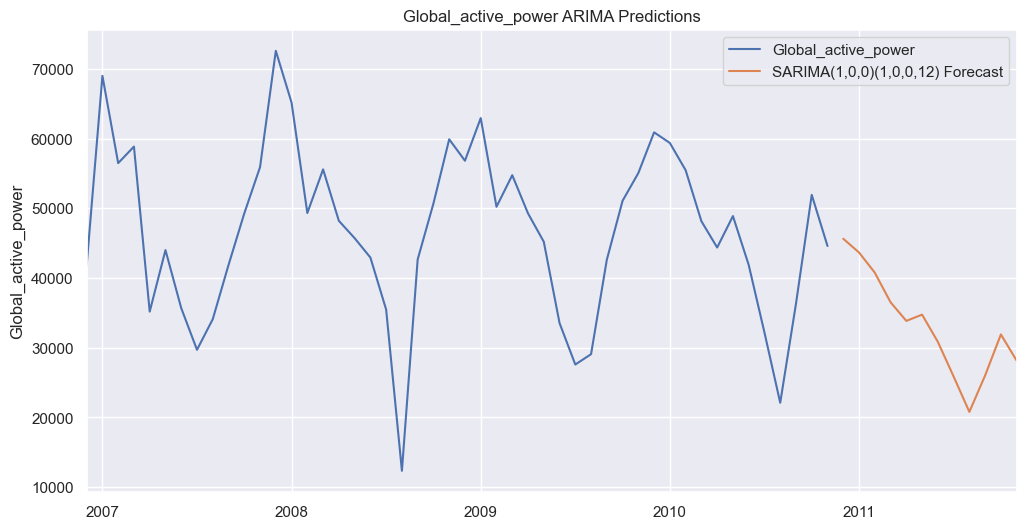

In [63]:
ax = dfm['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Generally good results, however, TES appears to be the best fit

## ARIMA for sub3

In [64]:
stepwise_fit = auto_arima(dfm['Sub_metering_3'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=896.020, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=902.085, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=896.496, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=900.363, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=906.679, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=902.328, Time=0.07 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=897.979, Time=0.26 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=897.924, Time=0.31 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=897.343, Time=0.13 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=894.681, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=900.554, Time=0.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=896.370, Time=0.20 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=896.672, Time=0.20 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -443.341
Date:                              Fri, 14 Apr 2023   AIC                            894.681
Time:                                      16:28:06   BIC                            901.015
Sample:                                           0   HQIC                           896.892
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.784e+04   8272.263      2.156      0.031    1624.644    3.41e+04
ar.L1          0.6068      0.125      4.840      0.000       0.361       0.853
ma.S.L12      -0.6210      0.320     -1.938      0.053      -1.249       0.007
sigma2        3.2e+09      0.057   5.59e+10      0.000     3.2e+09     3.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):                 5.88
Prob(Q):                              0.19   Prob(JB):                         0.05
Heteroskedasticity (H):               0.38   Skew:                            -0.12
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+28. Standard errors may be unstable.
"""

In [65]:
auto_arima(dfm['Sub_metering_3'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -594.361
Date:                Fri, 14 Apr 2023   AIC                           1194.722
Time:                        16:28:08   BIC                           1200.335
Sample:                             0   HQIC                          1196.843
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.38e+05    2.7e+04      5.111      0.000    8.51e+04    1.91e+05
ar.L1          0.4962      0.104      4.760      0.000       0.292       0.701
sigma2      3.174e+09      0.006   5.28e+11      0.000    3.17e+09    3.17e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.78   Prob(JB):                         0.31
Heteroskedasticity (H):               1.03   Skew:                            -0.52
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.02e+33. Standard errors may be unstable.
"""

In [66]:
start=len(month_train)
end=len(month_train)+len(month_test)-1
predictions_arima3 = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'Sub_metering_3')]

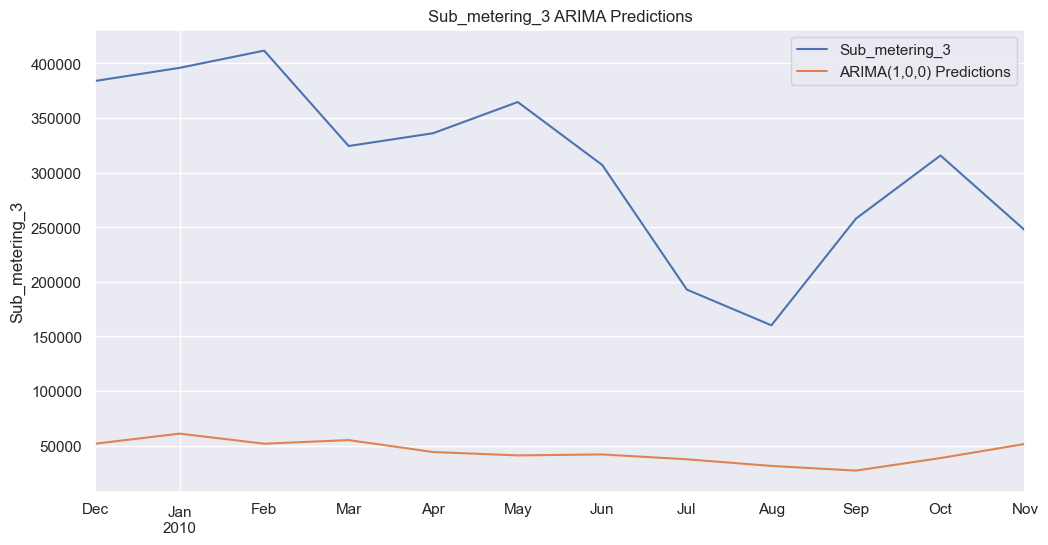

In [67]:
title = 'Sub_metering_3 ARIMA Predictions'
ylabel= 'Sub_metering_3'
xlabel='' # we don't really need a label here

ax = month_test['Sub_metering_3'].plot(legend=True,figsize=(12,6),title=title)
predictions_arima3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [68]:
sub3_ARIMA_MAE = mean_absolute_error(month_test['Sub_metering_3'], predictions_arima3)
sub3_ARIMA_RMSE = np.sqrt(mean_squared_error(month_test['Sub_metering_3'], predictions_arima3))
sub3_ARIMA_STD = month_test['Sub_metering_3'].std()

print("MAE:", sub3_ARIMA_MAE, "RMSE:", sub3_ARIMA_RMSE, " STD:", sub3_ARIMA_STD)

MAE: 263661.95705090737 RMSE: 272867.99704750266  STD: 79706.64793060446


#### Again errors higher than TES!

#### Checking SARIMA

In [69]:
auto_arima(dfm['Sub_metering_3'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -594.361
Date:                Fri, 14 Apr 2023   AIC                           1194.722
Time:                        16:28:16   BIC                           1200.335
Sample:                             0   HQIC                          1196.843
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.38e+05    2.7e+04      5.111      0.000    8.51e+04    1.91e+05
ar.L1          0.4962      0.104      4.760      0.000       0.292       0.701
sigma2      3.174e+09      0.006   5.28e+11      0.000    3.17e+09    3.17e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.78   Prob(JB):                         0.31
Heteroskedasticity (H):               1.03   Skew:                            -0.52
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.02e+33. Standard errors may be unstable.
"""

In [70]:
model_sarima3 = SARIMAX(month_train['Sub_metering_3'],order=(1,0,0),seasonal_order=(1,0,0,12))
results_sarima3 = model_sarima3.fit()
results_sarima3.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25640D+01    |proj g|=  7.46641D-02

At iterate    5    f=  1.25583D+01    |proj g|=  4.97113D-02

At iterate   10    f=  1.25510D+01    |proj g|=  4.05775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     19      1     0     0   4.666D-07   1.255D+01
  F =   12.550905315493374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Sub_metering_3   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -451.833
Date:                            Fri, 14 Apr 2023   AIC                            909.665
Time:                                    16:28:17   BIC                            914.416
Sample:                                12-31-2006   HQIC                           911.323
                                     - 11-30-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9594      0.064     14.961      0.000       0.834       1.085
ar.S.L12       0.1390      0.204      0.682      0.495      -0.260       0.538
sigma2      4.437e+09   7.46e-13   5.95e+21      0.000    4.44e+09    4.44e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.88   Jarque-Bera (JB):                 6.78
Prob(Q):                              0.17   Prob(JB):                         0.03
Heteroskedasticity (H):               0.34   Skew:                             0.49
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+39. Standard errors may be unstable.
"""

In [71]:
predictions_sarima3 = results_sarima3.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Predictions')

In [72]:
sub3_SARIMA_MAE = mean_absolute_error(month_test['Sub_metering_3'], predictions_sarima3)
sub3_SARIMA_RMSE = np.sqrt(mean_squared_error(month_test['Sub_metering_3'], predictions_sarima3))
sub3_SARIMA_STD = month_test['Sub_metering_3'].std()

print("MAE:", sub3_SARIMA_MAE, "RMSE:", sub3_SARIMA_RMSE, " STD:", sub3_SARIMA_RMSE)

MAE: 58434.766279809985 RMSE: 64359.00675856738  STD: 64359.00675856738


#### Again TES is better than SARIMA; checking predictions anyway

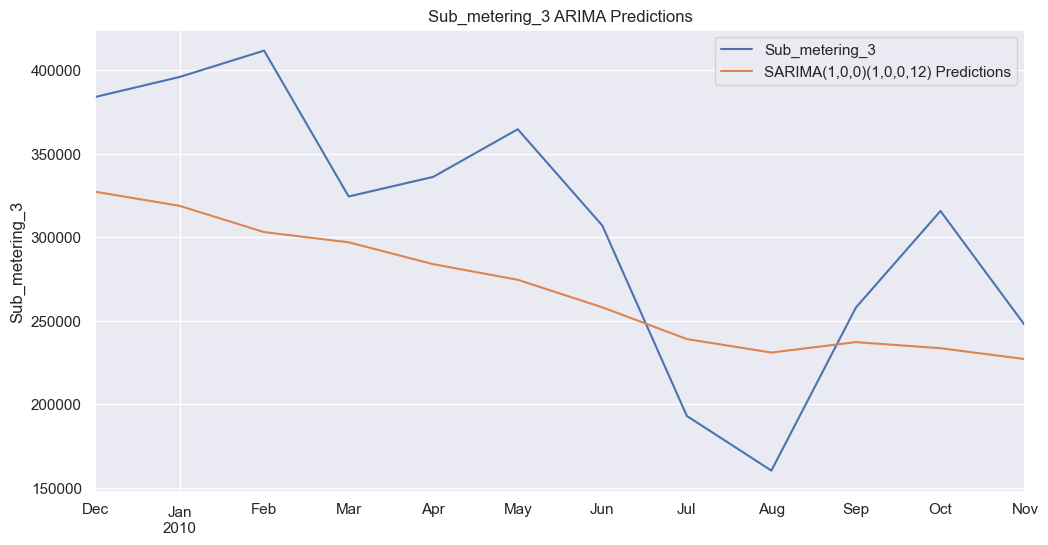

In [73]:
ax = month_test['Sub_metering_3'].plot(legend=True,figsize=(12,6),title=title)
predictions_sarima3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [74]:
model = SARIMAX(dfm['Sub_metering_3'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
fcast = results.predict(len(dfm),len(dfm)+11,typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Forecast')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25303D+01    |proj g|=  1.68229D-01

At iterate    5    f=  1.25065D+01    |proj g|=  5.42338D-02

At iterate   10    f=  1.25040D+01    |proj g|=  5.90630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.358D-06   1.250D+01
  F =   12.504011015350443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


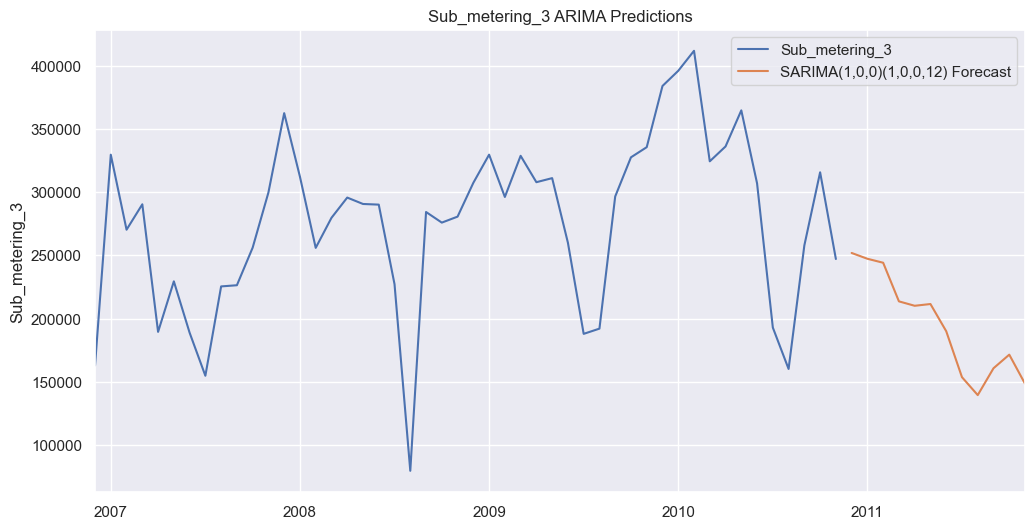

In [75]:
ax = dfm['Sub_metering_3'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Summary

In [76]:
# Global Active Power
print("\nGlobal Active Power Triple Exponential Smoothing model")
print("MAE:", power_TES_MAE, "RMSE:", power_TES_RMSE, " STD:", power_TES_STD)

print("\nGlobal Active Power ARIMA model")
print("MAE:", power_ARIMA_MAE, "RMSE:", power_ARIMA_RMSE, " STD:", power_ARIMA_STD)

print("\nGlobal Active Power SARIMA model")
print("MAE:", power_SARIMA_MAE, "RMSE:", power_SARIMA_RMSE, " STD:", power_SARIMA_STD)


Global Active Power Triple Exponential Smoothing model
MAE: 4865.596608567722 RMSE: 6123.373769643343  STD: 11336.01333086247

Global Active Power ARIMA model
MAE: 7892.399963508037 RMSE: 10264.385779796223  STD: 11336.01333086247

Global Active Power SARIMA model
MAE: 7387.993377361109 RMSE: 8442.932711586682  STD: 11336.01333086247


In [77]:
# Sub_metering3
print("\nSub_metering3 Triple Exponential Smoothing model")
print("MAE:", sub3_TES_MAE, "RMSE:", sub3_TES_RMSE, " STD:", sub3_TES_STD)

print("\nSub_metering3 ARIMA model")
print("MAE:", sub3_ARIMA_MAE, "RMSE:", sub3_ARIMA_RMSE, " STD:", sub3_ARIMA_STD)

print("\nSub_metering3 SARIMA model")
print("MAE:", sub3_SARIMA_MAE, "RMSE:", sub3_SARIMA_RMSE, " STD:", sub3_SARIMA_STD)


Sub_metering3 Triple Exponential Smoothing model
MAE: 40680.96114813715 RMSE: 52074.70087441025  STD: 79706.64793060446

Sub_metering3 ARIMA model
MAE: 263661.95705090737 RMSE: 272867.99704750266  STD: 79706.64793060446

Sub_metering3 SARIMA model
MAE: 58434.766279809985 RMSE: 64359.00675856738  STD: 79706.64793060446


### In this case Triple Exponential Smooting is the best fit, as it provides predictions with lowest error